In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Load the dataset
file_path = "/content/borg_traces_data.csv"
df = pd.read_csv(file_path)

# Check first few rows
df.head()

# Convert columns containing dictionary-like strings into actual dictionaries
def extract_resource_value(resource_str, key):
    try:
        resource_dict = ast.literal_eval(resource_str)  # Convert string to dictionary
        return resource_dict.get(key, None)
    except (SyntaxError, ValueError):
        return None

# Extract CPU & memory values
df['cpu_usage'] = df['average_usage'].apply(lambda x: extract_resource_value(x, 'cpus'))
df['memory_usage'] = df['assigned_memory'].apply(lambda x: extract_resource_value(x, 'memory'))

# Convert to numeric
df['cpu_usage'] = pd.to_numeric(df['cpu_usage'])
df['memory_usage'] = pd.to_numeric(df['memory_usage'])

# Check cleaned data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       2612 non-null   int64  
 1   time                             2612 non-null   int64  
 2   instance_events_type             2612 non-null   int64  
 3   collection_id                    2612 non-null   int64  
 4   scheduling_class                 2612 non-null   int64  
 5   collection_type                  2612 non-null   int64  
 6   priority                         2612 non-null   int64  
 7   alloc_collection_id              2612 non-null   int64  
 8   instance_index                   2612 non-null   int64  
 9   machine_id                       2612 non-null   int64  
 10  resource_request                 2603 non-null   object 
 11  constraint                       2612 non-null   object 
 12  collections_events_t

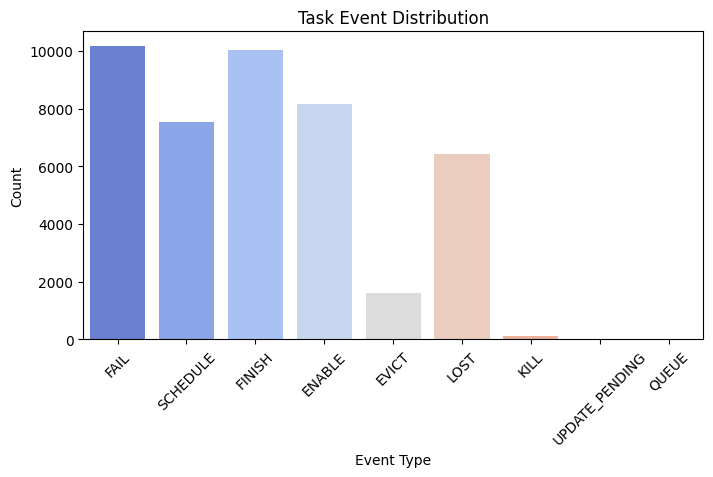

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=df['event'], hue=df['event'], palette='coolwarm', legend=False)  # Modified line
plt.title("Task Event Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Ensure priority and scheduling_class exist
if 'priority' in df.columns and 'scheduling_class' in df.columns:
    # Create a crosstab
    priority_scheduling = pd.crosstab(df['priority'], df['scheduling_class'])

    # Create a heatmap
    fig = px.imshow(priority_scheduling,
                    labels={'x': 'Scheduling Class', 'y': 'Priority Level', 'color': 'Count'},
                    color_continuous_scale='viridis',  # Change color theme if needed
                    title='Priority vs. Scheduling Class')

    fig.show()
else:
    print("Error: 'priority' or 'scheduling_class' columns not found in the dataset.")


In [ ]:
import plotly.express as px
import pandas as pd
import ast

# Function to safely extract 'cpus' from JSON-like string
def extract_cpus(value):
    try:
        if isinstance(value, str):  # Ensure it's a string before parsing
            data = ast.literal_eval(value)
            return data.get('cpus', None)
    except (ValueError, SyntaxError):
        pass
    return None

# Apply extraction function
df['requested_cpu'] = df['resource_request'].apply(extract_cpus)
df['actual_cpu'] = df['average_usage'].apply(extract_cpus)

# Drop NaN values to avoid issues
df_cleaned = df.dropna(subset=['requested_cpu', 'actual_cpu'])

# Scatter plot for requested vs. actual CPU usage
fig = px.scatter(
    df_cleaned,
    x='requested_cpu',
    y='actual_cpu',
    color='event',  # Ensure 'event' exists in the dataset
    title='Requested vs. Actual CPU Usage',
    labels={'requested_cpu': 'Requested CPU', 'actual_cpu': 'Actual CPU'}
)

# Add a dashed reference line (y = x) for perfect request matching
fig.add_shape(
    type="line",
    x0=min(df_cleaned['requested_cpu']),
    y0=min(df_cleaned['requested_cpu']),
    x1=max(df_cleaned['requested_cpu']),
    y1=max(df_cleaned['requested_cpu']),
    line=dict(dash="dash", color="red")
)

fig.show()


In [ ]:
fig = px.histogram(df, x='priority', title='Task Priority Distribution')
fig.show()

In [ ]:
import plotly.express as px

# Filter only failed tasks
failed_tasks = df[df['event'] == 'FAIL']

# Count failures per machine and get the top 10
machine_failures = failed_tasks['machine_id'].value_counts().head(10).reset_index()
machine_failures.columns = ['machine_id', 'failure_count']

# Create the bar plot with enhancements
fig = px.bar(
    machine_failures,
    x='machine_id',
    y='failure_count',
    title='🚨 Top 10 Machines by Task Failures',
    text='failure_count',  # Show counts on bars
    color='failure_count',  # Color intensity based on failure count
    color_continuous_scale='reds'  # Red shades for failure severity
)

# Improve layout for better readability
fig.update_layout(
    xaxis_title='Machine ID',
    yaxis_title='Number of Failures',
    xaxis=dict(tickangle=-45),  # Rotate x-axis labels for readability
    bargap=0.2,  # Adjust bar spacing
    template="plotly_white"  # Clean theme for better visibility
)

# Show the updated plot
fig.show()


In [ ]:
import plotly.express as px

fig = px.histogram(
    df,
    x='cluster',
    color='event',
    barmode='group',
    title='Task Outcomes by Cluster'
)
fig.show()

In [ ]:
import pandas as pd
import numpy as np
import ast

# Load dataset
df = pd.read_csv("borg_traces_data.csv")

# Function to extract 'cpus' and 'memory' from JSON-like columns
def extract_value(value, key):
    try:
        data = ast.literal_eval(value)
        return data.get(key, None)
    except (ValueError, SyntaxError):
        return None

# Extract features
df['requested_cpu'] = df['resource_request'].apply(lambda x: extract_value(x, 'cpus'))
df['requested_memory'] = df['resource_request'].apply(lambda x: extract_value(x, 'memory'))
df['actual_cpu'] = df['average_usage'].apply(lambda x: extract_value(x, 'cpus'))
df['actual_memory'] = df['average_usage'].apply(lambda x: extract_value(x, 'memory'))

# Drop rows with missing values
df = df.dropna()

# Convert categorical columns to numerical
df['event'] = df['event'].astype('category').cat.codes
df['scheduling_class'] = df['scheduling_class'].astype('category').cat.codes
df['priority'] = df['priority'].astype('category').cat.codes

# Select features and target
features = ['requested_cpu', 'requested_memory', 'priority', 'scheduling_class']
target = 'actual_cpu'  # We will predict actual CPU usage

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

print("Data Preprocessing Complete ✅")


<ipython-input-19-51ac929c3bcc>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-51ac929c3bcc>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-19-51ac929c3bcc>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Data Preprocessing Complete ✅


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf:.4f}")


Random Forest MAE: 0.0027


In [ ]:
import xgboost as xgb

# Train model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.4f}")


XGBoost MAE: 0.0036


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train.values, axis=1)
X_test_lstm = np.expand_dims(X_test.values, axis=1)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=1)

# Predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f"LSTM MAE: {mae_lstm:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0099
Epoch 2/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0064
Epoch 3/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0063
Epoch 4/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0060
Epoch 5/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0057
Epoch 6/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0057
Epoch 7/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0057
Epoch 8/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0058
Epoch 9/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0058
Epoch 10/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0056
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM MAE: 0.0051


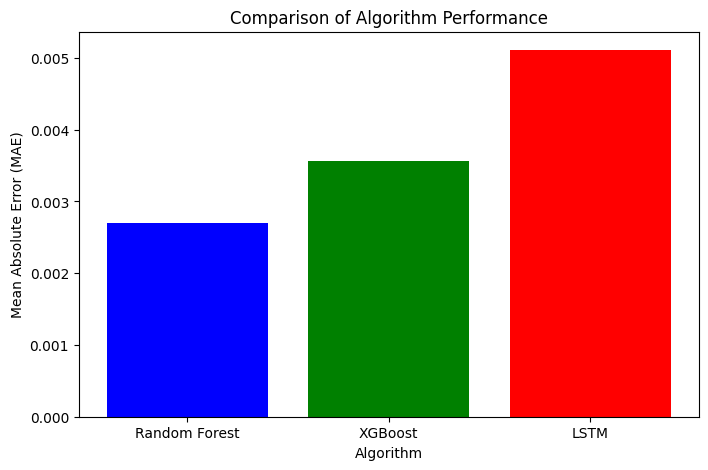

In [ ]:
import matplotlib.pyplot as plt

# Compare MAE
models = ['Random Forest', 'XGBoost', 'LSTM']
mae_values = [mae_rf, mae_xgb, mae_lstm]

# Bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, mae_values, color=['blue', 'green', 'red'])
plt.xlabel("Algorithm")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Comparison of Algorithm Performance")
plt.show()


In [ ]:
import plotly.express as px

# Create dataframe for visualization
pred_df = pd.DataFrame({
    'Actual': y_test[:100].values,
    'Random Forest': y_pred_rf[:100],
    'XGBoost': y_pred_xgb[:100],
    'LSTM': y_pred_lstm[:100].flatten()
})

# Line plot for predictions
fig = px.line(pred_df, title='Actual vs. Predicted CPU Usage (First 100 Samples)')
fig.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.express as px

# Selecting Features
features = ['priority', 'scheduling_class', 'requested_cpu']
target = 'actual_cpu'

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Training Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicting CPU usage
df['predicted_cpu'] = lr.predict(df[features])


In [ ]:
fig = px.scatter(df, x='actual_cpu', y='predicted_cpu', title='Actual vs Predicted CPU Usage')
fig.add_shape(type="line", x0=0, y0=0, x1=max(df['actual_cpu']), y1=max(df['predicted_cpu']), line=dict(dash="dash", color="red"))
fig.show()
